### Assignment 4 (COUNTER TREND) - Robo Advisors & Systematic Trading
### Name: Shravan Khunti
### NET ID: ssk10036
### MS in Data Science
### NYU Center for Data Sciene

# **Countertrend Strategy Backtest**

P = 2.2: Sharpe Ratio = -0.3118, Number of Signals = 361
P = 2.0: Sharpe Ratio = -0.2449, Number of Signals = 487
P = 1.8: Sharpe Ratio = -0.4098, Number of Signals = 659
P = 1.6: Sharpe Ratio = -0.5647, Number of Signals = 886
P = 1.4: Sharpe Ratio = -0.7961, Number of Signals = 1167
P = 1.2: Sharpe Ratio = -1.3595, Number of Signals = 1461
P = 1.0: Sharpe Ratio = -1.9273, Number of Signals = 1839
P = 0.8: Sharpe Ratio = -2.7506, Number of Signals = 2286
Sharpe Ratio (Buy & Hold): 0.5239

Confusion Matrix for P = 2.2:
Strategy Positive & Market Positive: 49
Strategy Negative & Market Negative: 165
Strategy Positive & Market Negative: 142
Strategy Negative & Market Positive: 5


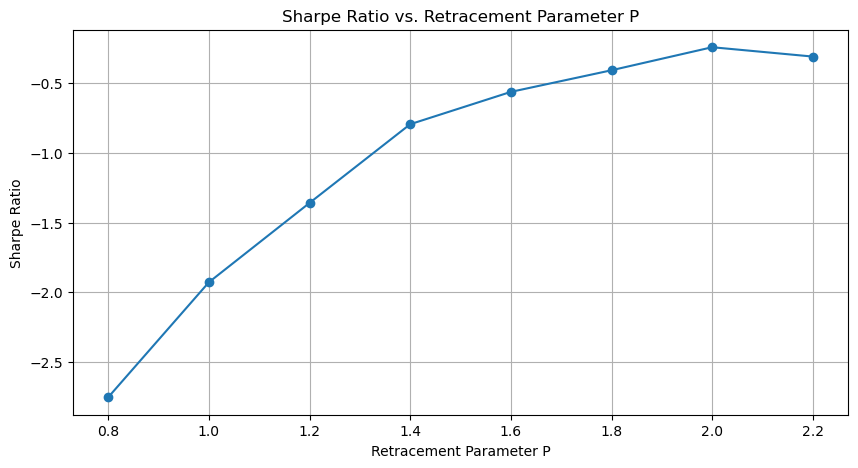

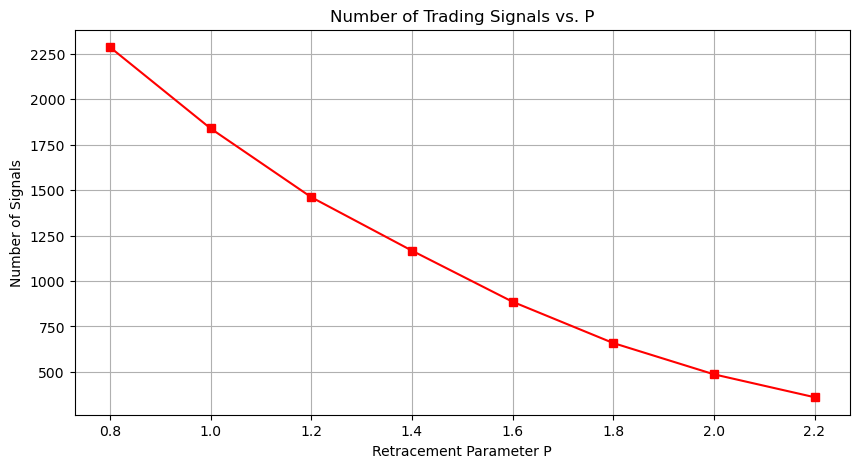

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_excel(r"C:\Users\shrav\Downloads\COUNTER_TREND_DATA (2).xlsx")

# Shift headers up by one row because labels in excel start from row 2
df.columns = df.iloc[0]
df = df[1:].reset_index(drop=True)

# Convert necessary columns to numeric
df[['Open', 'High', 'Low', 'Close', 'PC(%)']] = df[['Open', 'High', 'Low', 'Close', 'PC(%)']].apply(pd.to_numeric)

# Compute DayRange (High - Low)
df['DayRange'] = df['High'] - df['Low']

# Compute 20-day rolling average of DayRange (Av20R) starting from row 22
df['Av20R'] = df['DayRange'].rolling(window=20).mean()

# Compute PrvHiWRoll (Previous day’s high, roll adjusted), starting from row 23
df['PrvHiWRoll'] = df['High'].shift(1)

# Define retracement parameters to compare
P_values = [2.2, 2.0, 1.8, 1.6, 1.4, 1.2, 1.0, 0.8]
sharpe_ratios = {}
num_signals = {}

# Initialize the confusion matrix
conf_matrix = {
    "Strategy Positive & Market Positive": 0,
    "Strategy Negative & Market Negative": 0,
    "Strategy Positive & Market Negative": 0,
    "Strategy Negative & Market Positive": 0
}

def categorize_returns(strategy_ret, market_ret):
    if strategy_ret > 0 and market_ret > 0:
        return "Strategy Positive & Market Positive"
    elif strategy_ret < 0 and market_ret < 0:
        return "Strategy Negative & Market Negative"
    elif strategy_ret > 0 and market_ret < 0:
        return "Strategy Positive & Market Negative"
    elif strategy_ret < 0 and market_ret > 0:
        return "Strategy Negative & Market Positive"
    else:
        return None

for P in P_values:
    temp_df = df.copy()
    
    # Compute HitLevel
    temp_df['HitLevel'] = temp_df['PrvHiWRoll'] - P * temp_df['Av20R']
    temp_df = temp_df.dropna(subset=['HitLevel'])
    
    # Check if HitLevel was hit
    temp_df['Hit?'] = temp_df['Low'] < temp_df['HitLevel']
    
    # Entry price if HitLevel is hit
    temp_df['HitAt'] = np.where(temp_df['Hit?'], temp_df['HitLevel'], np.nan)
    
    # Exit price (close price on entry day)
    temp_df['ExitPr'] = np.where(temp_df['Hit?'], temp_df['Close'], np.nan)
    
    # Calculate return to close (Ret2C)
    temp_df['Ret2C'] = np.where(temp_df['Hit?'], (temp_df['ExitPr'] - temp_df['HitAt']) / temp_df['HitAt'], 0)
    
    # Compute Sharpe Ratio
    def sharpe_ratio(returns):
        returns = returns.dropna()
        if len(returns) < 2:
            return np.nan  # Avoid division by zero
        return np.sqrt(260) * np.mean(returns) / np.std(returns)  # Adjusted formula
    
    sharpe_ratios[P] = sharpe_ratio(temp_df['Ret2C'])
    num_signals[P] = temp_df['Hit?'].sum()
    
    # Categorize returns for P = 2.2
    if P == 2.2:
        for _, row in temp_df.iterrows():
            category = categorize_returns(row['Ret2C'], row['PC(%)'] / 100)
            if category:
                conf_matrix[category] += 1

# Print Sharpe Ratios and Number of Signals for different P values
for P in P_values:
    print(f"P = {P}: Sharpe Ratio = {sharpe_ratios[P]:.4f}, Number of Signals = {num_signals[P]}")

# Compute Buy & Hold returns (unchanged)
df['BuyNhold'] = df['PC(%)'] / 100  # Convert percentage to decimal

# Sharpe Ratio for Buy & Hold
sharpe_buyhold = np.sqrt(260) * np.mean(df['BuyNhold'].dropna()) / np.std(df['BuyNhold'].dropna())
print(f"Sharpe Ratio (Buy & Hold): {sharpe_buyhold:.4f}")

# Print confusion matrix results
print("\nConfusion Matrix for P = 2.2:")
for key, value in conf_matrix.items():
    print(f"{key}: {value}")

# Plot Sharpe Ratios vs P Values
plt.figure(figsize=(10, 5))
plt.plot(P_values, [sharpe_ratios[P] for P in P_values], marker='o', linestyle='-')
plt.xlabel('Retracement Parameter P')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio vs. Retracement Parameter P')
plt.grid()
plt.show()

# Plot Number of Signals vs P Values
plt.figure(figsize=(10, 5))
plt.plot(P_values, [num_signals[P] for P in P_values], marker='s', linestyle='-', color='red')
plt.xlabel('Retracement Parameter P')
plt.ylabel('Number of Signals')
plt.title('Number of Trading Signals vs. P')
plt.grid()
plt.show()

# Countertrend Strategy Analysis

## Overview
This analysis evaluates the **long-side countertrend strategy** with varying retracement parameters (`P`) and compares its **Sharpe Ratio** against a buy-and-hold strategy. The study examines whether a lower retracement threshold improves the performance of the strategy and how frequently it generates trade signals.

---

## Sharpe Ratio and Signal Count by `P`

| P Value | Sharpe Ratio | Number of Signals |
|---------|--------------|------------------|
| 2.2     | -0.3118      | 361              |
| 2.0     | -0.2449      | 487              |
| 1.8     | -0.4098      | 659              |
| 1.6     | -0.5647      | 886              |
| 1.4     | -0.7961      | 1167             |
| 1.2     | -1.3595      | 1461             |
| 1.0     | -1.9273      | 1839             |
| 0.8     | -2.7506      | 2286             |

**Sharpe Ratio for Buy & Hold:** **0.5239**

---

## Observations

1. **Negative Sharpe Ratios Across All `P` Values**  
   - The countertrend strategy consistently underperforms, delivering negative risk-adjusted returns for all retracement values.
   - As `P` decreases, the Sharpe Ratio worsens, suggesting that lowering the retracement threshold introduces **more losing trades**.

2. **Increasing Trade Frequency with Lower `P`**  
   - A smaller `P` increases the number of trade signals, rising from **361 trades (P=2.2) to 2,286 trades (P=0.8)**.
   - This suggests that a lower threshold **triggers more trades**, but they **do not improve profitability**.

3. **Comparison with Buy & Hold**  
   - The **buy-and-hold strategy outperforms the countertrend system**, with a **Sharpe Ratio of 0.5239**.
   - The countertrend strategy’s negative Sharpe Ratio indicates that its returns are highly volatile and generally unprofitable.

---

## Confusion Matrix (`P=2.2`)

| Scenario                                   | Count |
|--------------------------------------------|-------|
| Strategy Positive & Market Positive        | 49    |
| Strategy Negative & Market Negative        | 165   |
| Strategy Positive & Market Negative        | 142   |
| Strategy Negative & Market Positive        | 5     |

### Interpretation:

- The **strategy aligns with market trends** more often than not (165 times both were negative).
- However, it frequently **goes against the market** (142 cases where the strategy was positive but the market was negative).
- The **best-case scenario (both positive) occurs less frequently (49 times)**.
- The worst-case scenario (**strategy negative & market positive**) is rare (5 times), but still exists.

---

## Conclusion

- **The countertrend strategy is not viable in its current form** as it generates **negative Sharpe Ratios** and underperforms the market.
- **Lowering `P` increases trade frequency but does not improve returns**.
- **The strategy struggles in trending markets**, as indicated by the confusion matrix.
- **Further refinements**—such as adjusting exit rules, filtering trades, or testing the short side—are needed to make the strategy profitable.

---

# **Extra Credit**

In [3]:
# Extra Credit Part 1: Calculate Total Returns in Each Scenario
scenario_returns = {key: 0 for key in conf_matrix.keys()}
for _, row in temp_df.iterrows():
    category = categorize_returns(row['Ret2C'], row['PC(%)'] / 100)
    if category:
        scenario_returns[category] += row['Ret2C']

print("\nTotal Returns in Each Scenario:")
for key, value in scenario_returns.items():
    print(f"{key}: {value:.4f}")

# Extra Credit Part 2: Sharpe Ratios with Zero vs Blank Returns
sharpe_zero_returns = {}
sharpe_blank_returns = {}

for P in P_values:
    temp_df = df.copy()
    temp_df['HitLevel'] = temp_df['PrvHiWRoll'] - P * temp_df['Av20R']
    temp_df = temp_df.dropna(subset=['HitLevel'])
    temp_df['Hit?'] = temp_df['Low'] < temp_df['HitLevel']
    temp_df['Ret2C'] = np.where(temp_df['Hit?'], (temp_df['Close'] - temp_df['HitLevel']) / temp_df['HitLevel'], np.nan)
    
    # Zero Return Assumption (fill missing trades with 0)
    temp_df['Ret2C_Zero'] = temp_df['Ret2C'].fillna(0)
    sharpe_zero_returns[P] = sharpe_ratio(temp_df['Ret2C_Zero'])
    
    # Blank Return Assumption (ignore missing trades)
    sharpe_blank_returns[P] = sharpe_ratio(temp_df['Ret2C'])

print("\nSharpe Ratios with Zero Returns:")
for P in P_values:
    print(f"P = {P}: {sharpe_zero_returns[P]:.4f}")

print("\nSharpe Ratios with Blank Returns:")
for P in P_values:
    print(f"P = {P}: {sharpe_blank_returns[P]:.4f}")


Total Returns in Each Scenario:
Strategy Positive & Market Positive: 4.0674
Strategy Negative & Market Negative: -10.6891
Strategy Positive & Market Negative: 1.0215
Strategy Negative & Market Positive: -0.7432

Sharpe Ratios with Zero Returns:
P = 2.2: -0.3118
P = 2.0: -0.2449
P = 1.8: -0.4098
P = 1.6: -0.5647
P = 1.4: -0.7961
P = 1.2: -1.3595
P = 1.0: -1.9273
P = 0.8: -2.7506

Sharpe Ratios with Blank Returns:
P = 2.2: -1.1002
P = 2.0: -0.7431
P = 1.8: -1.0700
P = 1.6: -1.2722
P = 1.4: -1.5643
P = 1.2: -2.3970
P = 1.0: -3.0378
P = 0.8: -3.9032


# Extra Credit Analysis: Countertrend Strategy Performance

## Total Returns in Each Market Condition

| Scenario                                   | Total Return |
|--------------------------------------------|-------------|
| Strategy Positive & Market Positive        | 4.0674      |
| Strategy Negative & Market Negative        | -10.6891    |
| Strategy Positive & Market Negative        | 1.0215      |
| Strategy Negative & Market Positive        | -0.7432     |

### Observations:
1. **Best Scenario:**  
   - The strategy performs best when **both the market and the strategy are positive** (**+4.0674**).  
   - This suggests the strategy works in **mean-reverting conditions where prices bounce back up** after triggering an entry.

2. **Worst Scenario:**  
   - The largest losses occur when **both the market and strategy are negative** (**-10.6891**).  
   - This means the countertrend approach struggles when markets continue to trend downward instead of reverting.

3. **Mixed Outcomes:**  
   - When the **strategy is positive but the market is negative**, there is still a **small gain (+1.0215)**, implying that some trades capture local reversals despite a broader downtrend.
   - When the **strategy is negative but the market is positive**, losses are minimal (**-0.7432**), suggesting that the strategy avoids significant drawdowns in rising markets.

---

## Sharpe Ratios: Zero vs. Blank Returns

| P Value | Sharpe Ratio (Zero Returns) | Sharpe Ratio (Blank Returns) |
|---------|-----------------------------|-----------------------------|
| 2.2     | -0.3118                      | -1.1002                     |
| 2.0     | -0.2449                      | -0.7431                     |
| 1.8     | -0.4098                      | -1.0700                     |
| 1.6     | -0.5647                      | -1.2722                     |
| 1.4     | -0.7961                      | -1.5643                     |
| 1.2     | -1.3595                      | -2.3970                     |
| 1.0     | -1.9273                      | -3.0378                     |
| 0.8     | -2.7506                      | -3.9032                     |

### Observations:
1. **Zero vs. Blank Returns**  
   - The **Sharpe Ratio is always worse when blank returns are ignored** compared to filling non-trading days with zero.
   - This is expected because **excluding blank returns increases return volatility**, worsening risk-adjusted performance.

2. **Impact of Lower `P` Values**  
   - Lowering `P` increases trade frequency but leads to **significantly worse Sharpe Ratios**.
   - At **P = 0.8**, both Sharpe Ratios become extremely negative (**-2.7506 for zero returns and -3.9032 for blank returns**), indicating severe underperformance.
   - **Higher `P` values (2.2 or 2.0) perform the least badly**, suggesting that **a more selective entry threshold prevents unnecessary trades**.

---

## Key Takeaways:
- The **strategy works best when the market aligns with countertrend signals**.
- **Significant losses occur in trending markets**, especially during **market-wide selloffs**.
- **Lowering `P` increases trading frequency but decreases Sharpe Ratios**.
- **Using blank returns makes the strategy look even worse**, reinforcing that **non-trading days reduce volatility**.

---

# **Extra Fun Part**


Short Strategy Performance:
P = 2.2: Sharpe Ratio = -0.6222, Number of Signals = 269
P = 2.0: Sharpe Ratio = -0.8979, Number of Signals = 416
P = 1.8: Sharpe Ratio = -0.8044, Number of Signals = 625
P = 1.6: Sharpe Ratio = -1.2745, Number of Signals = 900
P = 1.4: Sharpe Ratio = -1.6371, Number of Signals = 1243
P = 1.2: Sharpe Ratio = -2.1636, Number of Signals = 1651
P = 1.0: Sharpe Ratio = -2.8167, Number of Signals = 2190
P = 0.8: Sharpe Ratio = -3.6481, Number of Signals = 2771


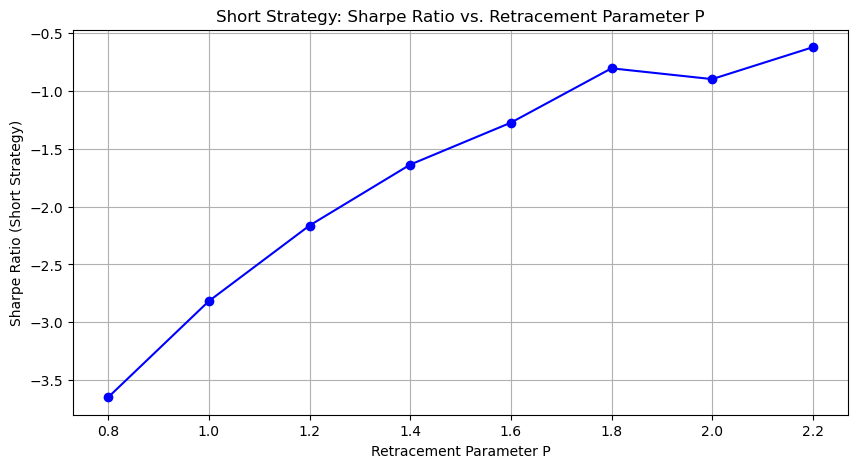

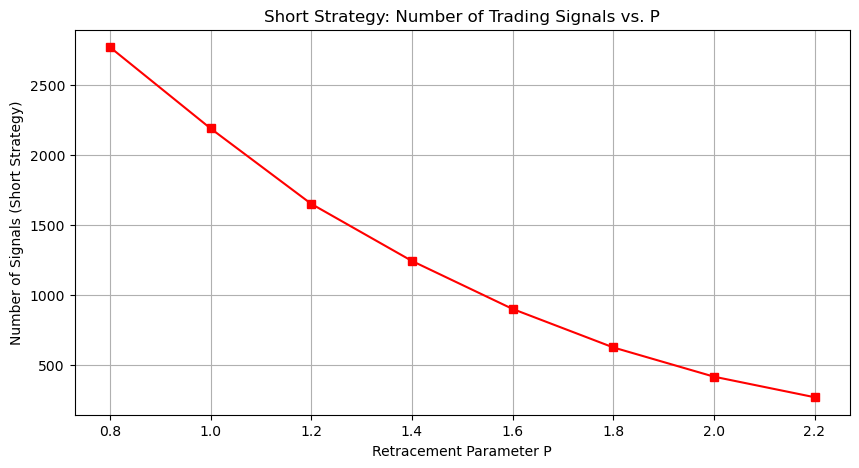

In [6]:
# Convert necessary columns to numeric
df[['Open', 'High', 'Low', 'Close', 'PC(%)']] = df[['Open', 'High', 'Low', 'Close', 'PC(%)']].apply(pd.to_numeric)

# Compute DayRange (High - Low)
df['DayRange'] = df['High'] - df['Low']

# Compute 20-day rolling average of DayRange (Av20R) starting from row 22
df['Av20R'] = df['DayRange'].rolling(window=20).mean()

# Compute PrvLoWRoll (Previous day’s low, roll adjusted), starting from row 23
df['PrvLoWRoll'] = df['Low'].shift(1)

# Define retracement parameters to compare
P_values = [2.2, 2.0, 1.8, 1.6, 1.4, 1.2, 1.0, 0.8]
sharpe_ratios_short = {}
num_signals_short = {}

for P in P_values:
    temp_df = df.copy()
    
    # Compute Short Entry Level
    temp_df['ShortHitLevel'] = temp_df['PrvLoWRoll'] + P * temp_df['Av20R']
    temp_df = temp_df.dropna(subset=['ShortHitLevel'])
    
    # Check if ShortHitLevel was hit
    temp_df['ShortHit?'] = temp_df['High'] > temp_df['ShortHitLevel']
    
    # Entry price if ShortHitLevel is hit
    temp_df['ShortHitAt'] = np.where(temp_df['ShortHit?'], temp_df['ShortHitLevel'], np.nan)
    
    # Exit price (close price on entry day)
    temp_df['ShortExitPr'] = np.where(temp_df['ShortHit?'], temp_df['Close'], np.nan)
    
    # Calculate return to close (Ret2C) for short trades
    temp_df['ShortRet2C'] = np.where(temp_df['ShortHit?'], (temp_df['ShortHitAt'] - temp_df['ShortExitPr']) / temp_df['ShortHitAt'], 0)
    
    # Compute Sharpe Ratio for short strategy
    def sharpe_ratio(returns):
        returns = returns.dropna()
        if len(returns) < 2:
            return np.nan  # Avoid division by zero
        return np.sqrt(260) * np.mean(returns) / np.std(returns)  # Adjusted formula
    
    sharpe_ratios_short[P] = sharpe_ratio(temp_df['ShortRet2C'])
    num_signals_short[P] = temp_df['ShortHit?'].sum()

# Print Sharpe Ratios and Number of Signals for different P values (Short Side)
print("\nShort Strategy Performance:")
for P in P_values:
    print(f"P = {P}: Sharpe Ratio = {sharpe_ratios_short[P]:.4f}, Number of Signals = {num_signals_short[P]}")

# Plot Sharpe Ratios vs P Values for Short Strategy
plt.figure(figsize=(10, 5))
plt.plot(P_values, [sharpe_ratios_short[P] for P in P_values], marker='o', linestyle='-', color='blue')
plt.xlabel('Retracement Parameter P')
plt.ylabel('Sharpe Ratio (Short Strategy)')
plt.title('Short Strategy: Sharpe Ratio vs. Retracement Parameter P')
plt.grid()
plt.show()

# Plot Number of Signals vs P Values for Short Strategy
plt.figure(figsize=(10, 5))
plt.plot(P_values, [num_signals_short[P] for P in P_values], marker='s', linestyle='-', color='red')
plt.xlabel('Retracement Parameter P')
plt.ylabel('Number of Signals (Short Strategy)')
plt.title('Short Strategy: Number of Trading Signals vs. P')
plt.grid()
plt.show()

# Short-Side Countertrend Strategy Analysis

## Sharpe Ratio and Signal Count by `P`

| P Value | Sharpe Ratio | Number of Signals |
|---------|--------------|------------------|
| 2.2     | -0.6222      | 269              |
| 2.0     | -0.8979      | 416              |
| 1.8     | -0.8044      | 625              |
| 1.6     | -1.2745      | 900              |
| 1.4     | -1.6371      | 1243             |
| 1.2     | -2.1636      | 1651             |
| 1.0     | -2.8167      | 2190             |
| 0.8     | -3.6481      | 2771             |

---

## Observations:

1. **Consistently Negative Sharpe Ratios**  
   - The short-side countertrend strategy **performs worse than the long-side version**.
   - Sharpe Ratios become increasingly **negative** as `P` decreases, implying that **more frequent short trades result in greater losses**.

2. **Increasing Trade Frequency with Lower `P`**  
   - As `P` is lowered from **2.2 to 0.8**, the **number of signals increases from 269 to 2771**.
   - However, **more trades do not improve performance**, indicating that the **short strategy is ineffective across retracement levels**.

3. **Comparison to the Long-Side Strategy**  
   - Both **long and short countertrend strategies have negative Sharpe Ratios**, meaning they **fail to generate positive risk-adjusted returns**.
   - The **short-side strategy has an even worse performance**, suggesting that **shorting countertrend reversals is not profitable in this market**.

---

## Key Takeaways:

- **The short-side strategy does not work at any retracement level (`P`).**  
- **Increasing trade frequency worsens performance** rather than improving it.  
- The results suggest that **mean reversion works better on the long side** but remains unprofitable.  
- The **short strategy may work better in strongly trending markets**, but in this dataset, it fails.  

---
